## Biblioteki i funkcje

In [1]:
%run ../scripts/init0.py

%matplotlib inline

Wczytano podstawowe bilioteki!


In [2]:
%run ../scripts/my_functions_01.py

Wczytano funkcje użytkownika!


In [3]:
%run ../scripts/load_data.py 'base_wo'

zmienne: data. Pomyślnie wczytano dane podstawowe bez wartości odstających


## Missings

Usuwanie nan jest ważne z perspektywy tworzenia nowych zmiennych. W zależności od charakteru zmiennej nan zamieniam na średnią, medianę, czy wartość występującą najczęściej. Dodatkowo, przed usunięciem nan tworzę zmienne `missings_cnt...`

Liczba braków danych dla obserwacji

In [4]:
data['missing_cnt'] = data[data.columns.drop('is_bad')].apply(lambda x: x.isnull().sum(), axis = 1)

Czy brak danych w danej kolumnie

In [5]:
for column in data.columns.drop('is_bad'):
    missing = column, data[column].isnull().sum()
    if missing[1] > 0:
        data['is_missing_' + column] = data[column].isnull()
        print(missing)

('code_frequency_payments', 125)
('code_trustability', 5509)
('date_closed_account', 86081)
('date_final_payment', 11055)
('date_start_sth', 9765)
('duration_debt_days', 32164)
('val_balance_curr', 108615)
('val_debt_amount_max', 17)
('val_debt_curr', 32656)
('val_debt_overdue_curr', 17)
('val_payment_next', 93309)


## Daty

In [6]:
anomalies = pd.DataFrame()
for column in data.filter(regex='^date').columns:
    anomalies = anomalies.append(anomalies_summary(data[column]))
anomalies.sort_values(by='sum_of_p', ascending=False)

,col_name,n,n_nan,p_nan,n_neg,p_neg,n_zero,p_zero,n_inf,p_inf,n_blank,p_blank,n_distinct,col_type,max_val_change,sum_of_p
0,date_closed_account,170306,86081,0.505,0,0.0,0,0.0,0,0.0,0,0,2205,float64,0.995,0.505
0,date_final_payment,170306,11055,0.065,0,0.0,0,0.0,0,0.0,0,0,6883,float64,0.852,0.065
0,date_start_sth,170306,9765,0.057,0,0.0,0,0.0,0,0.0,0,0,2224,float64,0.993,0.057
0,date_confirmed,170306,0,0.000,0,0.0,0,0.0,0,0.0,0,0,2146,uint16,0.999,0.000
0,date_contract_open,170306,0,0.000,0,0.0,0,0.0,0,0.0,0,0,2889,uint16,0.991,0.000
0,date_request_b,170306,0,0.000,0,0.0,0,0.0,0,0.0,0,0,272,uint16,1.000,0.000


In [7]:
data.filter(regex='^date').describe().transpose()

,count,mean,std,min,25%,50%,75%,max
date_closed_account,84225.0,39906.419365,501.706657,37861.0,39520.0,40000.0,40343.0,40696.0
date_confirmed,170306.0,40241.864755,455.182272,38356.0,40066.0,40463.0,40552.0,40720.0
date_contract_open,170306.0,39777.631193,621.879843,36343.0,39278.0,39934.0,40334.0,40702.0
date_final_payment,159251.0,41472.456663,5297.338089,36799.0,39823.0,40474.0,41046.0,72961.0
date_request_b,170306.0,40575.127852,55.185545,40427.0,40529.0,40575.0,40621.0,40725.0
date_start_sth,160541.0,40224.991853,484.151390,37935.0,40004.0,40471.0,40561.0,40725.0


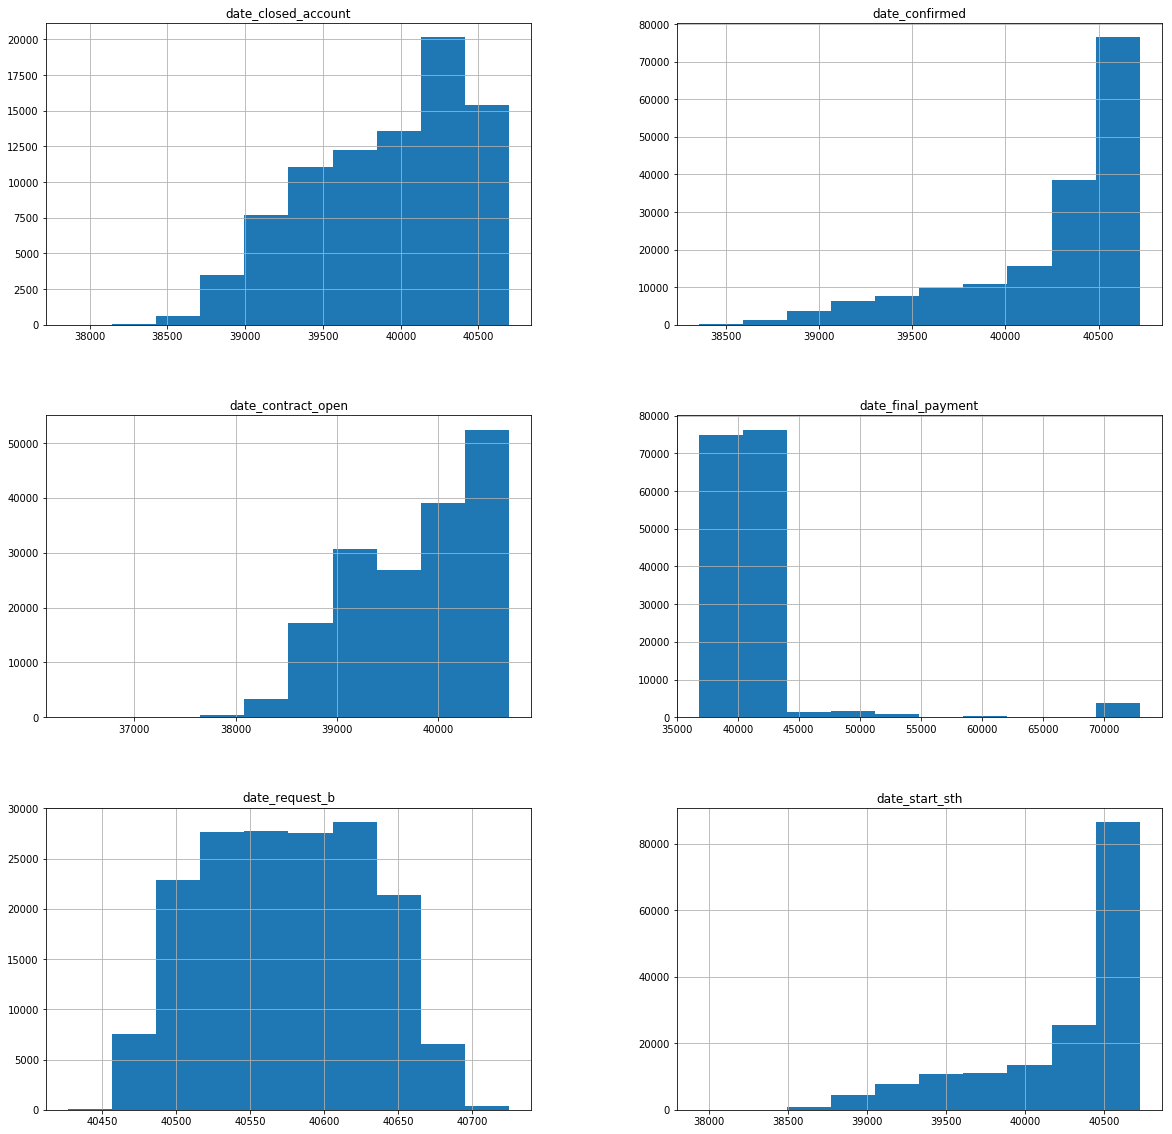

In [8]:
data[data.filter(regex='^date').columns].hist(figsize=(20,20));

Przemyślenia:

* `date_request_b` jest jakąś datą weryfikacyjną robioną regularnie w czasie trwania kredytu
* `date_final_payment` jest datą przyszłą stąd rozkład prawoskośny
* Pozostałe daty to coś co już się wydarzyło stąd rozkłady lewoskośne
* Trzy zmienne posiadają braki danych. W przypadku `date_closed_account` oraz `date_start_sth` jest to zrozumiałe (konto jest nadal aktywne oraz część osób nie wybrała jakiejś opcji). Natomiast braki dla `date_final_payment` są niezrozumiałe (tym bardziej, że dla niektórych takich osób `val_payment_next>0`) !!!
* Ciekawostka jest taka, że `date_final_payment` ma **3 razy więcej** różnych dat niż pozostałe zmienne, natomiast `date_request_b` ma ich **8-9 razy mniej** !!!

### duration_account_days

Połowa obserwacji `date_closed_account` to braki danych, dlatego generuję nową zmienną `duration_account_days = date_closed_account - date_contract_open`, gdzie braki danych zamieniam na `-1`

In [9]:
data['duration_account_days'] = data.date_closed_account.astype('float64') - data.date_contract_open.astype('float64')
data.duration_account_days = data.duration_account_days.fillna(-1)

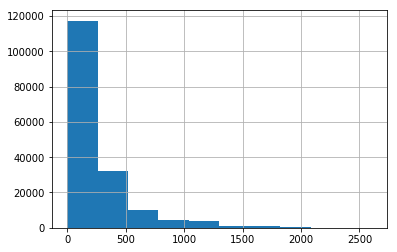

In [10]:
data.duration_account_days.hist();

### duration_confirmed_minus_contract_open_days

In [11]:
data['duration_confirmed_minus_contract_open_days'] = data.date_confirmed.astype('float64') - data.date_contract_open.astype('float64')

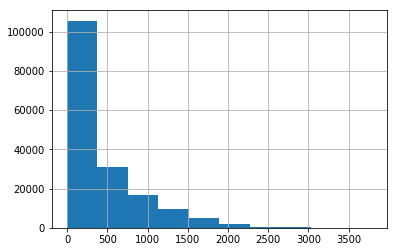

In [12]:
data['duration_confirmed_minus_contract_open_days'].hist();

In [13]:
data.loc[data.duration_confirmed_minus_contract_open_days < 0, 'duration_confirmed_minus_contract_open_days'] = 0

### duration_loan_short_yrs + duration_loan_yrs_is_geq_10 + date_final_payment_loan_short

Tworzę zmienne długość trwania pożyczki w latach oraz czy pożyczka dożywotnia (zakładam, że 10+)
Czyszczę zmienną date_final_payment tworząc date_final_payment_loan_short poprzez usunięcie wartości dla duration_loan_yrs_is_geq_10 == True

In [14]:
duration_loan_yrs = (data.date_final_payment.astype('float64') - data.date_contract_open.astype('float64'))/365

In [15]:
data[duration_loan_yrs < 0]

,cnt_delay_30d_59d,cnt_delay_5d_29d,cnt_delay_60d_89d,cnt_delay_upto_30d,cnt_delay_upto_5d,cnt_delay_upto_90d,code_b,code_contract_status,code_contract_type,code_frequency_payments,...,is_missing_date_final_payment,is_missing_date_start_sth,is_missing_duration_debt_days,is_missing_val_balance_curr,is_missing_val_debt_amount_max,is_missing_val_debt_curr,is_missing_val_debt_overdue_curr,is_missing_val_payment_next,duration_account_days,duration_confirmed_minus_contract_open_days
7413,0,0,0,0,0,1,1,13,9,3.0,...,False,False,False,True,False,False,False,True,1912.0,1912.0
15597,0,0,0,0,0,0,3,0,7,7.0,...,False,False,False,False,False,True,False,False,-1.0,1168.0
18836,0,0,0,0,0,0,3,0,7,7.0,...,False,False,False,False,False,True,False,False,-1.0,1311.0
25810,0,0,0,0,0,1,1,13,7,3.0,...,False,False,False,True,False,False,False,True,1543.0,1543.0
47821,0,0,0,0,0,0,3,0,7,7.0,...,False,False,False,False,False,True,False,False,-1.0,731.0
48078,0,0,0,0,0,1,1,13,7,3.0,...,False,False,False,True,False,False,False,True,1114.0,1114.0
69642,0,0,0,0,0,0,3,0,7,7.0,...,False,False,False,False,False,True,False,False,-1.0,483.0


In [16]:
duration_loan_yrs[duration_loan_yrs < 0] = np.nan # zamieniam na nan

In [17]:
data['duration_loan_yrs_is_geq_10'] = duration_loan_yrs.map(lambda x: x>=10)

In [18]:
duration_loan_yrs[duration_loan_yrs >= 10] = np.nan
data['duration_loan_short_yrs'] = duration_loan_yrs

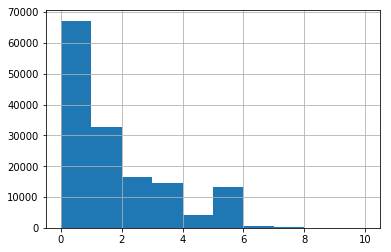

In [19]:
data.duration_loan_short_yrs.hist();

In [20]:
data['date_final_payment_loan_short'] = data.date_final_payment
data.loc[data.duration_loan_yrs_is_geq_10, 'date_final_payment_loan_short'] = np.nan

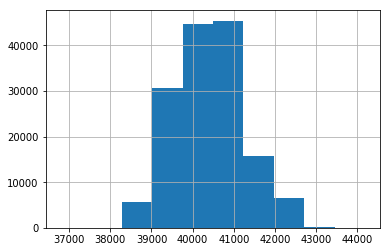

In [21]:
data.date_final_payment_loan_short.hist();

# Kwoty

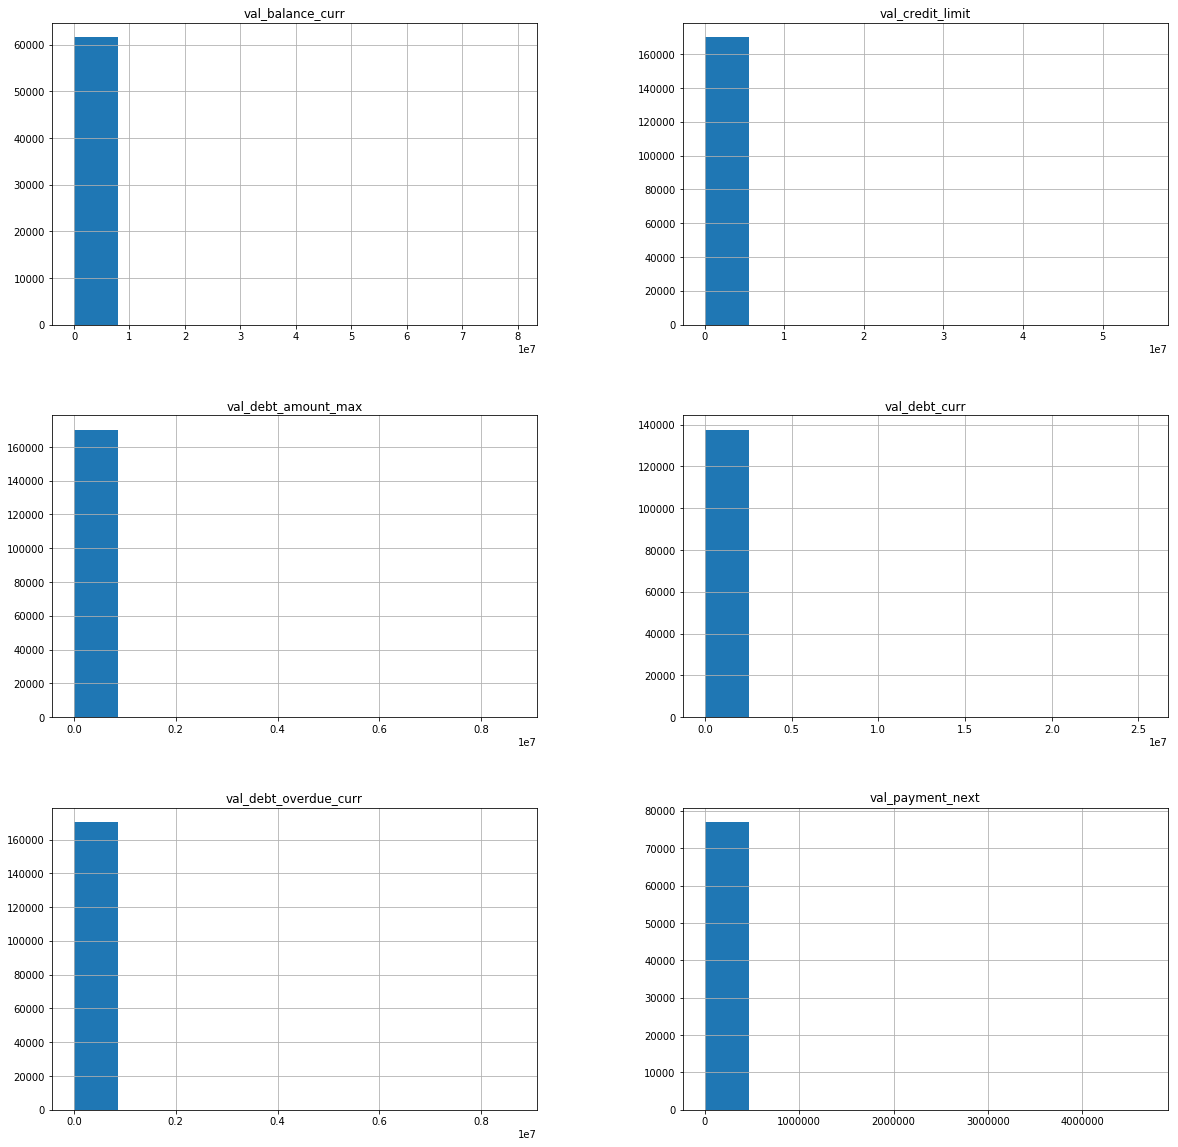

In [22]:
# wszystkie wartości mocno prawoskośne

data[data.filter(regex='^val').columns].hist(figsize=(20,20));

### _log

Logarytmujemy - udało się część rozkładów zrobić bardziej symetrycznymi - sporo wartości w okolicach 0

In [23]:
data['val_balance_curr_log'] = data.val_balance_curr.map(lambda x: np.log(x+1000))
data['val_credit_limit_log'] = data.val_credit_limit.map(lambda x: np.log(x+1000))
data['val_debt_amount_max_log'] = data.val_debt_amount_max.map(lambda x: np.log(x+1000))
data['val_debt_curr_log'] = data.val_debt_curr.map(lambda x: np.log(x+10000))
data['val_debt_overdue_curr_log'] = data.val_debt_overdue_curr.map(lambda x: np.log(x+1000))
data['val_payment_next_log'] = data.val_payment_next.map(lambda x: np.log(x+1000))

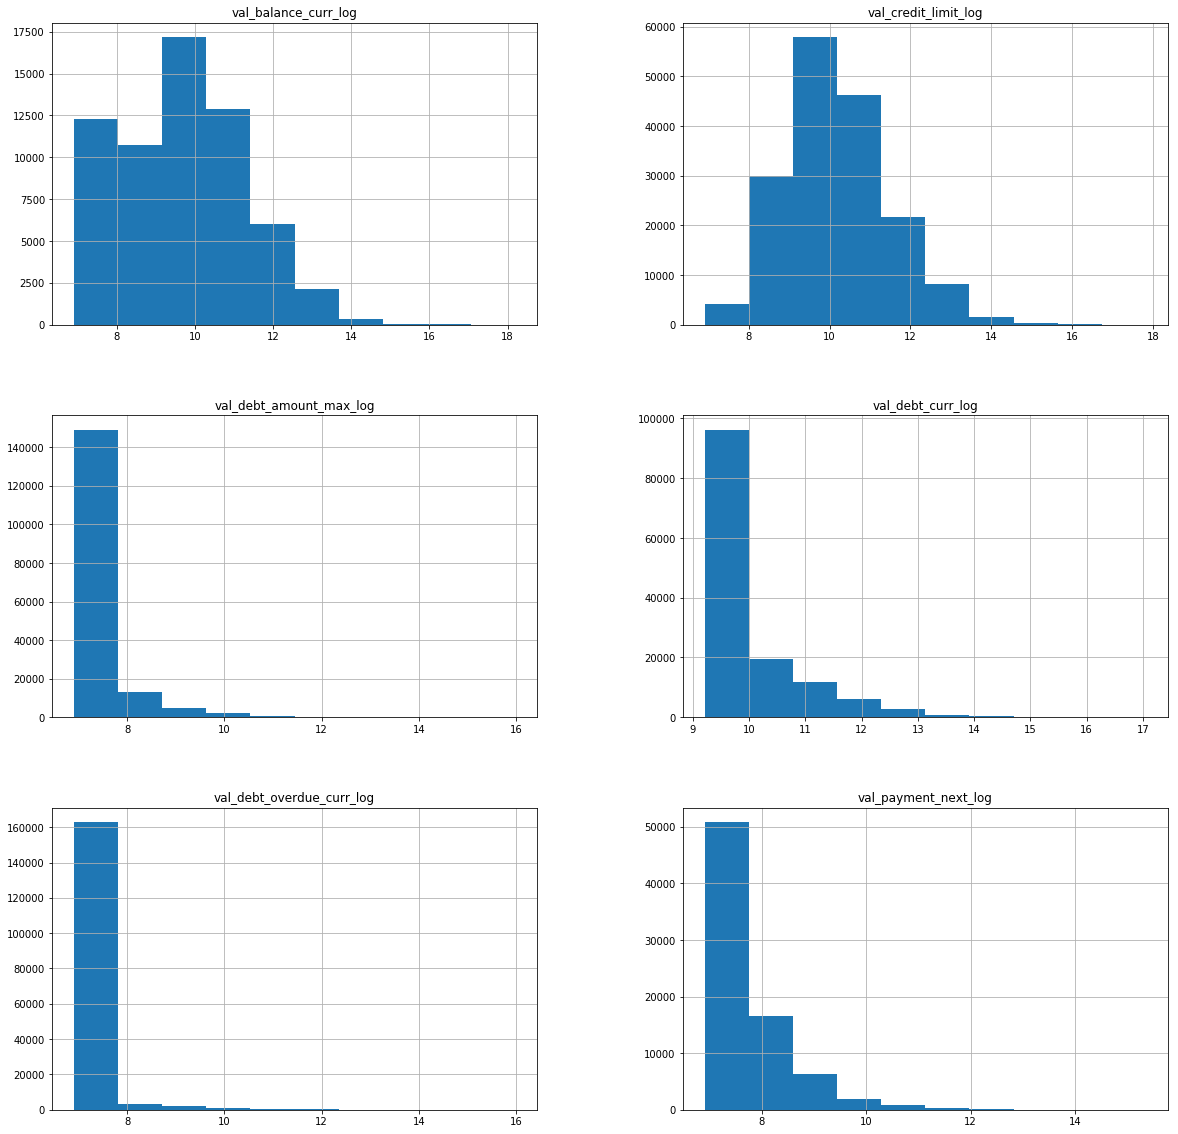

In [24]:
data[data.filter(regex='^val.*log').columns].hist(figsize=(20,20));

### val_payment_next_log_divide_debt_curr_log

Trochę przez przypadek, ale przynajmniej zmienna symetryczna

In [25]:
data['val_payment_next_log_divide_debt_curr_log'] = data.val_payment_next_log/data.val_debt_curr_log

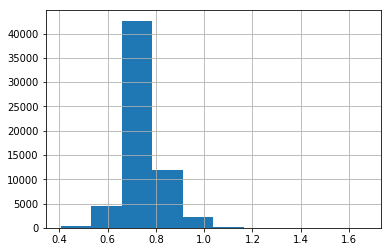

In [26]:
data['val_payment_next_log_divide_debt_curr_log'].hist();

# Kody

### code_b_is_1 + code_b_is_2 + code_b_is_3

Do zastanowienia się, czy 2 i 3 nie połączyć ze sobą

In [27]:
data.code_b.value_counts()

1    67605
3    61691
2    41010
Name: code_b, dtype: int64

In [28]:
data['code_b_is_1'] = data['code_b'].map(lambda x: x == 1)
data['code_b_is_2'] = data['code_b'].map(lambda x: x == 2)
data['code_b_is_3'] = data['code_b'].map(lambda x: x == 3)

In [29]:
data.groupby(['code_b', 'is_bad'])['code_b'].count().transform(lambda x: x / x.sum())

code_b  is_bad
1       0.0       0.351464
        1.0       0.042992
2       0.0       0.217766
        1.0       0.023019
3       0.0       0.329932
        1.0       0.034825
Name: code_b, dtype: float64

In [30]:
for column in data[data.filter(regex='^code_b_is').columns]:
    print(data[column].value_counts(normalize = True))

False    0.603038
True     0.396962
Name: code_b_is_1, dtype: float64
False    0.759198
True     0.240802
Name: code_b_is_2, dtype: float64
False    0.637764
True     0.362236
Name: code_b_is_3, dtype: float64


### code_contract_type_is_7 + code_contract_type_is_9 + code_contract_type_is_99

    1,4,6,10,11,14 dołączone do 7
    13 do 9
    12 do 99

In [31]:
data.groupby(['code_contract_type', 'is_bad'])['code_contract_type'].count().transform(lambda x: x / x.sum())

code_contract_type  is_bad
1                   0.0       0.017525
                    1.0       0.001282
4                   0.0       0.000006
6                   0.0       0.006105
                    1.0       0.000375
7                   0.0       0.159196
                    1.0       0.016987
9                   0.0       0.628061
                    1.0       0.070866
10                  0.0       0.003162
                    1.0       0.000260
11                  0.0       0.000411
                    1.0       0.000042
12                  0.0       0.000260
                    1.0       0.000036
13                  0.0       0.000212
                    1.0       0.000024
14                  0.0       0.000012
99                  0.0       0.084213
                    1.0       0.010966
Name: code_contract_type, dtype: float64

In [32]:
data.groupby(['code_contract_type', 'is_bad']).agg({'code_contract_type': len})

code_contract_type
code_contract_type is_bad                    
1                  0.0                   2899
                   1.0                    212
4                  0.0                      1
6                  0.0                   1010
                   1.0                     62
7                  0.0                  26335
                   1.0                   2810
9                  0.0                 103897
                   1.0                  11723
10                 0.0                    523
                   1.0                     43
11                 0.0                     68
                   1.0                      7
12                 0.0                     43
                   1.0                      6
13                 0.0                     35
                   1.0                      4
14                 0.0                      2
99                 0.0                  13931
                   1.0                   1814

In [33]:
data['code_contract_type_is_7'] = data['code_contract_type'].map(lambda x: (x == 7) | (x == 1) | (x == 4) | (x == 6) | (x == 10) | (x == 11) | (x == 14))
data['code_contract_type_is_9'] = data['code_contract_type'].map(lambda x: (x == 9) | (x == 13))
data['code_contract_type_is_99'] = data['code_contract_type'].map(lambda x: (x == 99) | (x == 12))

In [34]:
for column in data[data.filter(regex='^code_contract_type_is').columns]:
    print(data[column].value_counts(normalize = True))

False    0.796096
True     0.203904
Name: code_contract_type_is_7, dtype: float64
True     0.701026
False    0.298974
Name: code_contract_type_is_9, dtype: float64
False    0.90493
True     0.09507
Name: code_contract_type_is_99, dtype: float64


### code_contract_status_is_0 + code_contract_status_is_13 + code_contract_status_is_52

rozkład 14 podobny do 13 reszta z uwagi na małą liczebność dołączona do najliczniejszej grupy czyli tez 13

In [35]:
data.groupby(['code_contract_status', 'is_bad'])['code_contract_status'].count().transform(lambda x: x / x.sum())

code_contract_status  is_bad
0                     0.0       0.402291
                      1.0       0.047230
12                    0.0       0.000006
13                    0.0       0.440079
                      1.0       0.044618
14                    0.0       0.003845
                      1.0       0.000550
21                    0.0       0.000266
52                    0.0       0.052392
                      1.0       0.008427
61                    0.0       0.000284
                      1.0       0.000012
Name: code_contract_status, dtype: float64

In [36]:
data.groupby(['code_contract_status', 'is_bad']).agg({'code_contract_status': len})

code_contract_status
code_contract_status is_bad                      
0                    0.0                    66549
                     1.0                     7813
12                   0.0                        1
13                   0.0                    72800
                     1.0                     7381
14                   0.0                      636
                     1.0                       91
21                   0.0                       44
52                   0.0                     8667
                     1.0                     1394
61                   0.0                       47
                     1.0                        2

In [37]:
data['code_contract_status_is_0'] = data['code_contract_status'].map(lambda x: x == 0)
data['code_contract_status_is_13'] = data['code_contract_status'].map(lambda x: (x == 12) | (x == 13) | (x == 14) | (x == 21) | (x == 61))
data['code_contract_status_is_52'] = data['code_contract_status'].map(lambda x: x == 52)

In [38]:
for column in data[data.filter(regex='^code_contract_status_is').columns]:
    print(data[column].value_counts(normalize = True))

False    0.555342
True     0.444658
Name: code_contract_status_is_0, dtype: float64
False    0.50512
True     0.49488
Name: code_contract_status_is_13, dtype: float64
False    0.939538
True     0.060462
Name: code_contract_status_is_52, dtype: float64


### code_trustability__cnt

TODO:

In [39]:
for val in ['0', '1', '2', '3', '4', '5', '7', '9', 'A', 'X']:
    data['code_trustability_cnt_' + val.lower()] = data.code_trustability.map(lambda x: x if isinstance(x, float) else x.count(val))

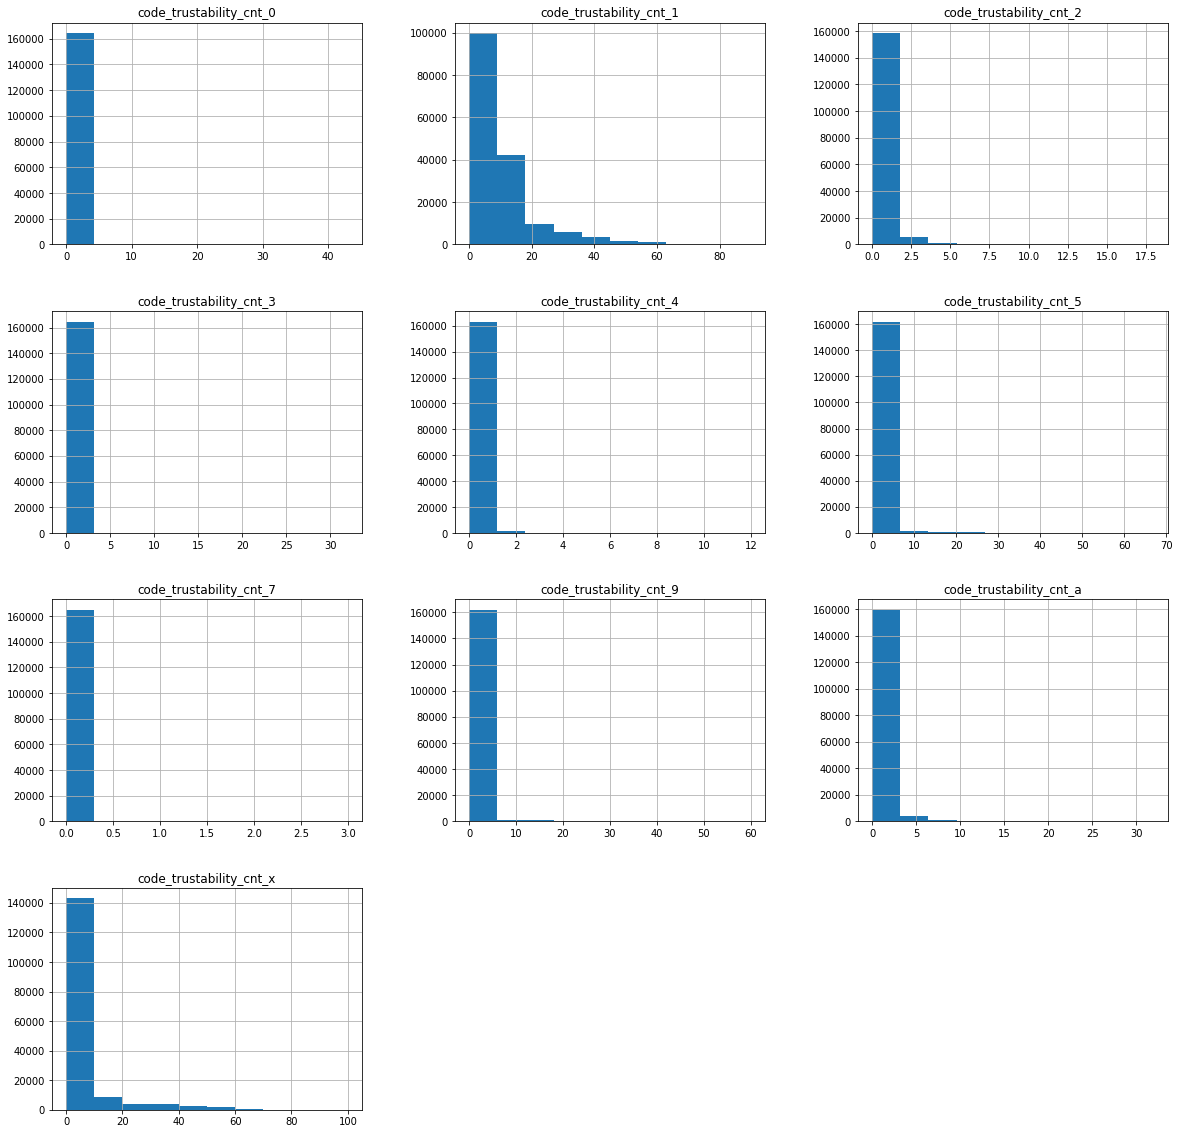

In [40]:
data[data.filter(regex='code_trustability_cnt_').columns].hist(figsize=(20,20));

In [41]:
for column in data[data.filter(regex='^code_trustability_cnt_').columns]:
    print(data[column].map(lambda x: 3 if x > 2 else x).value_counts(normalize = True))

0.0    0.840252
1.0    0.143334
2.0    0.011517
3.0    0.004897
Name: code_trustability_cnt_0, dtype: float64
3.0    0.811465
2.0    0.066609
0.0    0.065444
1.0    0.056482
Name: code_trustability_cnt_1, dtype: float64
0.0    0.871733
1.0    0.089462
2.0    0.024727
3.0    0.014078
Name: code_trustability_cnt_2, dtype: float64
0.0    0.913330
1.0    0.070262
2.0    0.012652
3.0    0.003756
Name: code_trustability_cnt_3, dtype: float64
0.0    0.933142
1.0    0.057434
2.0    0.007670
3.0    0.001754
Name: code_trustability_cnt_4, dtype: float64
0.0    0.933306
3.0    0.051706
1.0    0.008647
2.0    0.006341
Name: code_trustability_cnt_5, dtype: float64
0.0    0.998853
1.0    0.001110
2.0    0.000030
3.0    0.000006
Name: code_trustability_cnt_7, dtype: float64
0.0    0.974435
3.0    0.021851
1.0    0.002494
2.0    0.001220
Name: code_trustability_cnt_9, dtype: float64
0.0    0.782144
1.0    0.116543
3.0    0.054558
2.0    0.046754
Name: code_trustability_cnt_a, dtype: float64
0.0    0.4

In [42]:
for column in data[data.filter(regex='^code_trustability_cnt_').columns]:
    data[column + '_limit_to_2'] = data[column].map(lambda x: 2 if x > 1 else x)

### code_frequency_payments_is_0 + code_frequency_payments_is_0_0 + code_frequency_payments_is_3 + code_frequency_payments_is_3_0 + code_frequency_payments_is_7 + code_frequency_payments_is_7_0

    wszystko poza 0 i 7 do 3

In [43]:
data.groupby(['code_frequency_payments', 'is_bad'])['code_frequency_payments'].count().transform(lambda x: x / x.sum())

code_frequency_payments  is_bad
0.0                      0.0       0.100171
                         1.0       0.012292
1.0                      0.0       0.001658
                         1.0       0.000472
2.0                      0.0       0.018886
                         1.0       0.001742
3.0                      0.0       0.697817
                         1.0       0.076155
4.0                      0.0       0.000054
5.0                      0.0       0.000030
                         1.0       0.000006
6.0                      0.0       0.000236
                         1.0       0.000006
7.0                      0.0       0.080251
                         1.0       0.010187
8.0                      0.0       0.000024
9.0                      0.0       0.000012
Name: code_frequency_payments, dtype: float64

In [44]:
data.groupby(['code_frequency_payments', 'is_bad']).agg({'code_frequency_payments': len})

code_frequency_payments
code_frequency_payments is_bad                         
0.0                     0.0                     16559.0
                        1.0                      2032.0
1.0                     0.0                       274.0
                        1.0                        78.0
2.0                     0.0                      3122.0
                        1.0                       288.0
3.0                     0.0                    115354.0
                        1.0                     12589.0
4.0                     0.0                         9.0
5.0                     0.0                         5.0
                        1.0                         1.0
6.0                     0.0                        39.0
                        1.0                         1.0
7.0                     0.0                     13266.0
                        1.0                      1684.0
8.0                     0.0                         4.0
9.0                     0.0                         2.0

In [45]:
data['code_frequency_payments_is_0'] = data['code_frequency_payments'].map(lambda x: x == 0)
data['code_frequency_payments_is_3'] = data['code_frequency_payments'].map(lambda x: (x == 1) | (x == 2) | (x == 3) |(x == 4) | (x == 5) | (x == 6) | (x == 8) | (x == 9))
data['code_frequency_payments_is_7'] = data['code_frequency_payments'].map(lambda x: x == 7) 

In [46]:
for column in data[data.filter(regex='^code_frequency_payments_is_').columns]:
    print(data[column].map(lambda x: 3 if x > 2 else x).value_counts(normalize = True))

False    0.888595
True     0.111405
Name: code_frequency_payments_is_0, dtype: float64
True     0.798275
False    0.201725
Name: code_frequency_payments_is_3, dtype: float64
False    0.910414
True     0.089586
Name: code_frequency_payments_is_7, dtype: float64


# cnt delay

In [47]:
for column in data[data.filter(regex='^cnt_delay_').columns]:
    print(data[column].map(lambda x: 2 if x > 1 else x).value_counts(normalize = True))

0    0.884273
1    0.073180
2    0.042547
Name: cnt_delay_30d_59d, dtype: float64
0    0.780319
2    0.113525
1    0.106156
Name: cnt_delay_5d_29d, dtype: float64
0    0.936068
1    0.047937
2    0.015995
Name: cnt_delay_60d_89d, dtype: float64
0    0.749216
2    0.139337
1    0.111446
Name: cnt_delay_upto_30d, dtype: float64
0    0.924647
1    0.041666
2    0.033686
Name: cnt_delay_upto_5d, dtype: float64
0    0.918617
2    0.053932
1    0.027451
Name: cnt_delay_upto_90d, dtype: float64


In [48]:
for column in data[data.filter(regex='^cnt_delay_').columns]:
    data[column + '_limit_to_2'] = data[column].map(lambda x: 2 if x > 1 else x)

# Pozostałe

### id_customer_sqrt + id_customer_cnt + id_customer_is_unique

In [49]:
data['id_customer_sqrt'] = data['id_customer'].map(lambda x: np.sqrt(x + 1000)).astype('int16')

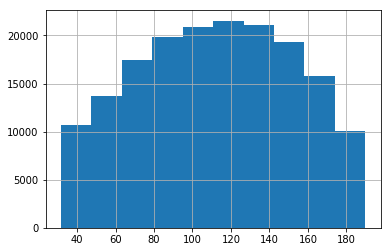

In [50]:
data.id_customer.map(lambda x: np.sqrt(x + 1000)).hist()

In [51]:
customers = data['id_customer'].value_counts().reset_index()
customers.columns = ['id_customer', 'id_customer_cnt']
customers

data = pd.merge(data, customers, on = 'id_customer')

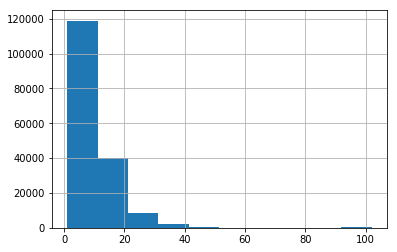

In [52]:
data.id_customer_cnt.hist()

In [53]:
data['id_customer_cnt_limit_to_2'] = data.id_customer_cnt.map(lambda x: 2 if x > 1 else x)

In [54]:
data.id_customer_cnt_limit_to_2.value_counts(normalize = True)

2    0.944242
1    0.055758
Name: id_customer_cnt_limit_to_2, dtype: float64

In [55]:
data.groupby(['id_customer_cnt_limit_to_2', 'is_bad'])['id_customer_cnt_limit_to_2'].count()

id_customer_cnt_limit_to_2  is_bad
1                           0.0         3779
                            1.0          836
2                           0.0       144965
                            1.0        15845
Name: id_customer_cnt_limit_to_2, dtype: int64

### duration_debt_days_limit

In [56]:
data['duration_debt_days_limit_1'] = data['duration_debt_days'].map(lambda x: 1 if x > 0 else x)

In [57]:
data.duration_debt_days_limit_1.value_counts(normalize = True)

0.0    0.92769
1.0    0.07231
Name: duration_debt_days_limit_1, dtype: float64

### loan_rate_limit

In [58]:
data['loan_rate_limit_5'] = data['loan_rate'].map(lambda x: 5 if x > 4 else x)

In [59]:
data.loan_rate_limit_5.value_counts(normalize = True)

0    0.915282
5    0.084718
Name: loan_rate_limit_5, dtype: float64

### Zapis

In [60]:
data.to_hdf('../data/data.base_wo_with_primary_fe.h5', 'base_wo_with_primary_fe', format='table')

In [61]:
print("Zapisano dane do pliku ../data/data.base_wo_with_primary_fe.h5")

Zapisano dane do pliku ../data/data.base_wo_with_primary_fe.h5
